#**Wearable EMG-Based Muscle Fatigue Detection Device**


This project proposes the development of a wearable
electromyography-based fatigue detection device designed to optimize workout performance by providing real-time feedback on muscle fatigue levels.

**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, find_peaks

**Upload EMG Data**

In [ ]:
# READ csv
url = 'https://raw.githubusercontent.com/steven-n-wilson/patternClassificationData/refs/heads/main/emg_data_left_02.csv'
data = pd.read_csv(url)

data.head()

print('First rows of data: ')
print(data.head())



First rows of data: 
   Timestamp (ms)  EMG Value
0               0        860
1               2        931
2               4        931
3               6        931
4               8        931


**Plot the Raw EMG Signal**

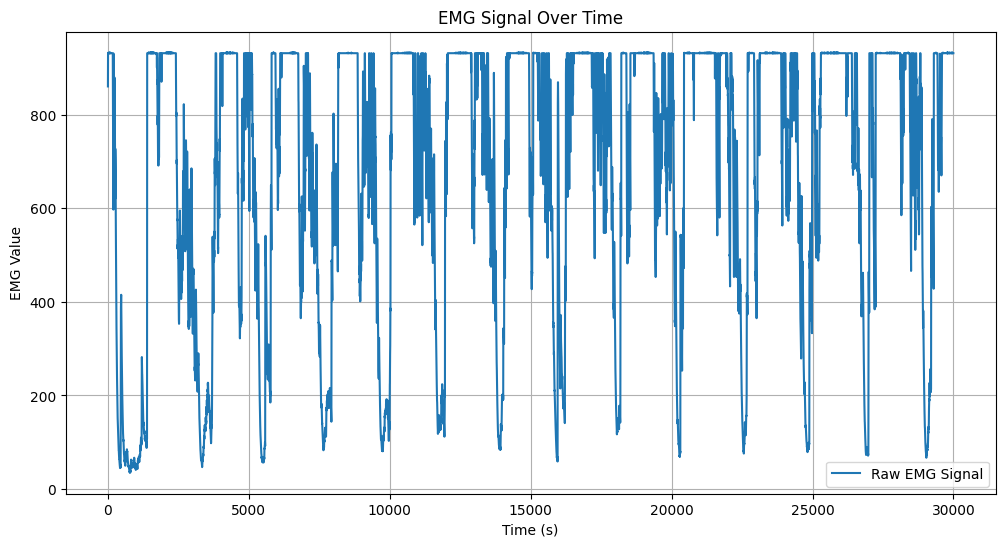

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp (ms)'], data['EMG Value'], label="Raw EMG Signal")
plt.title("EMG Signal Over Time")
plt.xlabel("Time (s)")
plt.ylabel("EMG Value")
plt.legend()
plt.grid()
plt.show()

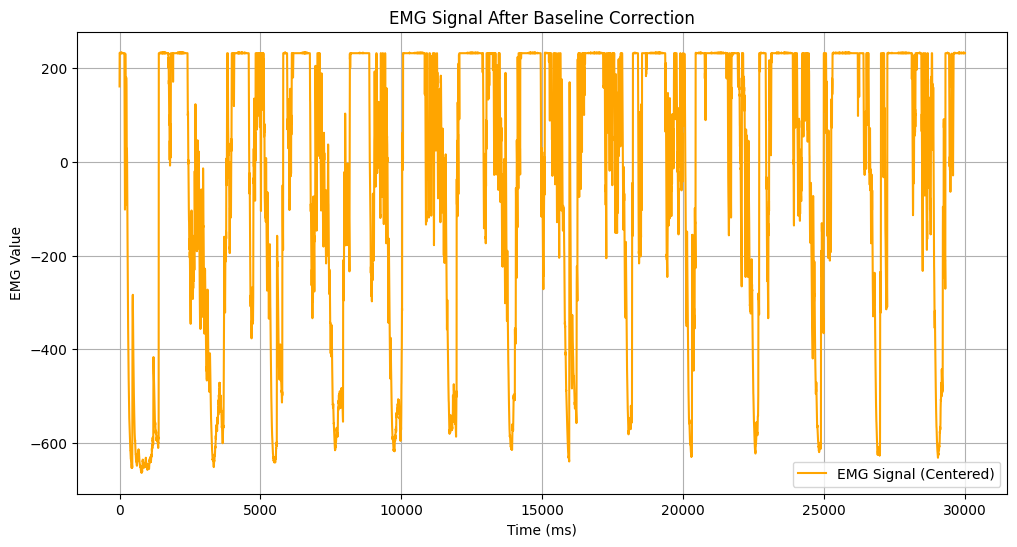

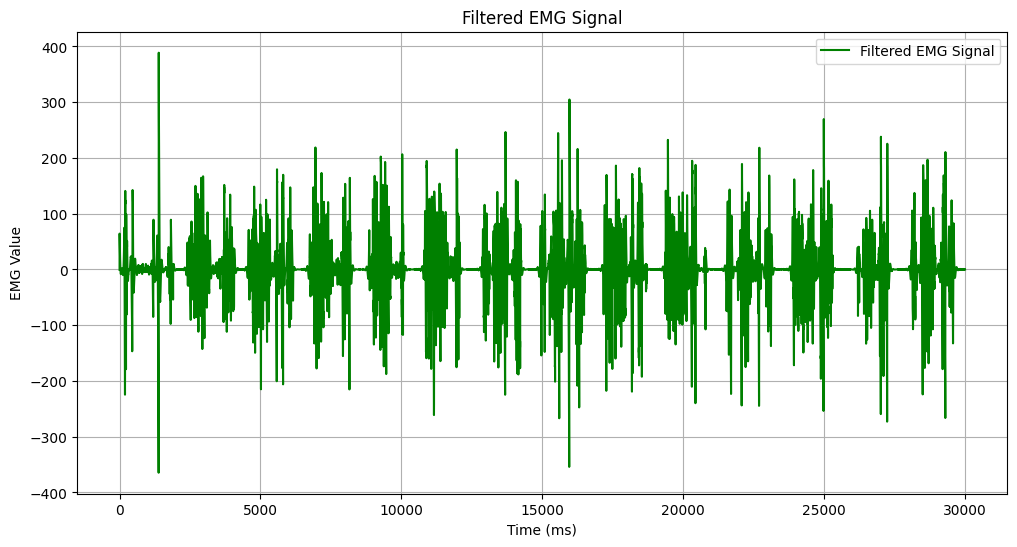

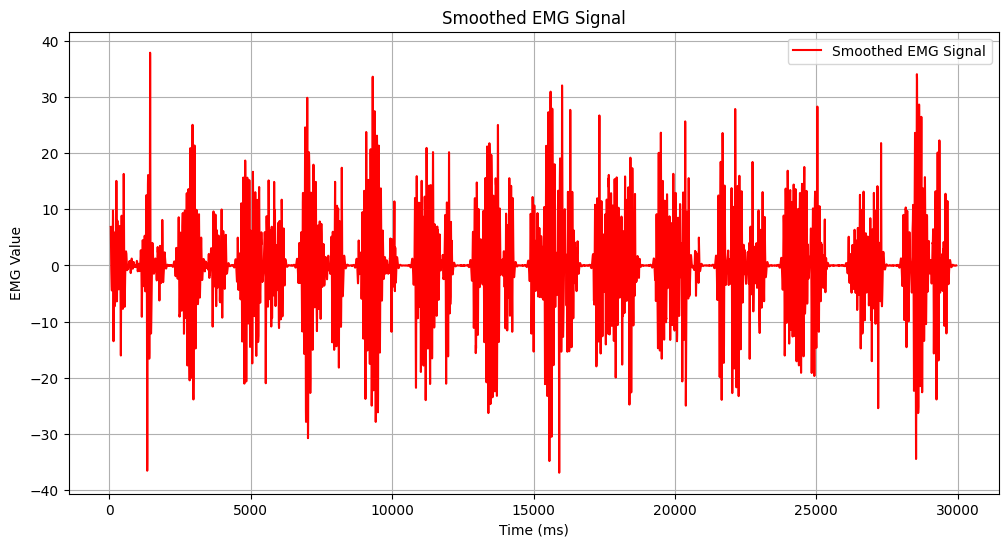

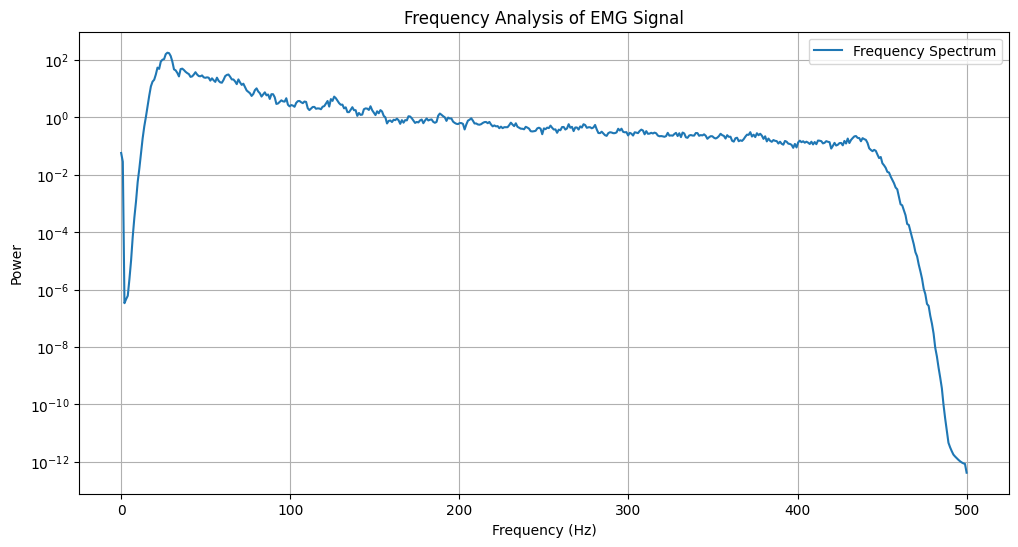

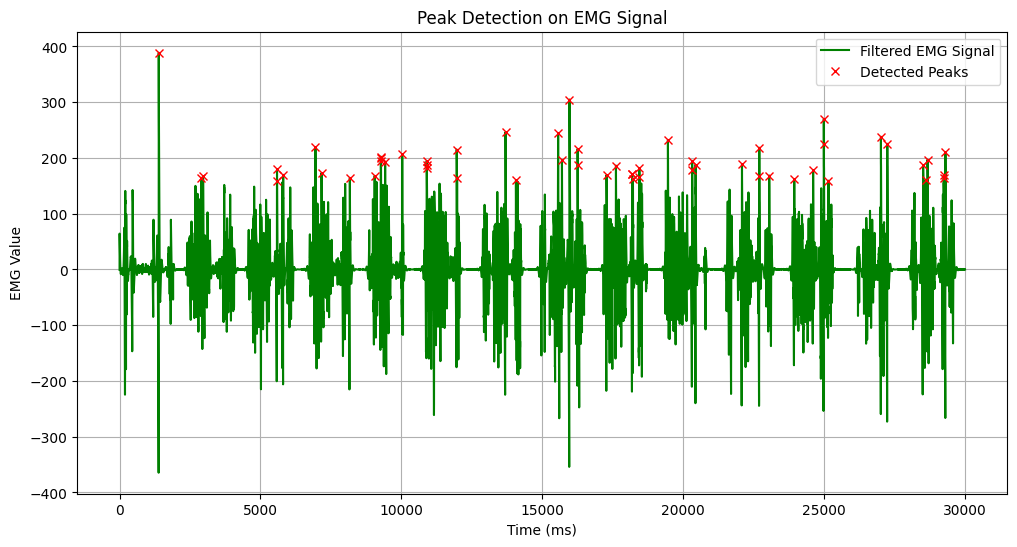

In [ ]:
# Step 2: Remove Baseline Bias
# Subtract the mean value to center the signal around zero
data['EMG_Centered'] = data['EMG Value'] - data['EMG Value'].mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp (ms)'], data['EMG_Centered'], label='EMG Signal (Centered)', color='orange')
plt.title("EMG Signal After Baseline Correction")
plt.xlabel("Time (ms)")
plt.ylabel("EMG Value")
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Apply Bandpass Filtering
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define filter parameters
lowcut = 20  # Lower cutoff frequency (Hz)
highcut = 450  # Upper cutoff frequency (Hz)
fs = 1000  # Sampling frequency (Hz) - Adjust based on your data

# Apply the bandpass filter
data['EMG_Filtered'] = bandpass_filter(data['EMG_Centered'], lowcut, highcut, fs)

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp (ms)'], data['EMG_Filtered'], label='Filtered EMG Signal', color='green')
plt.title("Filtered EMG Signal")
plt.xlabel("Time (ms)")
plt.ylabel("EMG Value")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Smoothing the Signal (Optional)
# Use a rolling average for smoothing
window_size = 50  # Adjust for smoothing effect
data['EMG_Smoothed'] = data['EMG_Filtered'].rolling(window=window_size, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp (ms)'], data['EMG_Smoothed'], label='Smoothed EMG Signal', color='red')
plt.title("Smoothed EMG Signal")
plt.xlabel("Time (ms)")
plt.ylabel("EMG Value")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Frequency Analysis (FFT)
frequencies, power_spectrum = welch(data['EMG_Filtered'], fs, nperseg=1024)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, power_spectrum, label='Frequency Spectrum')
plt.title("Frequency Analysis of EMG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Detect Peaks (Optional - e.g., Muscle Activation Events)
from scipy.signal import find_peaks

# Define a threshold for peak detection
threshold = data['EMG_Filtered'].std() * 3  # 3x standard deviation as a threshold
peaks, _ = find_peaks(data['EMG_Filtered'], height=threshold)

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp (ms)'], data['EMG_Filtered'], label='Filtered EMG Signal', color='green')
plt.plot(data['Timestamp (ms)'][peaks], data['EMG_Filtered'][peaks], "x", label='Detected Peaks', color='red')
plt.title("Peak Detection on EMG Signal")
plt.xlabel("Time (ms)")
plt.ylabel("EMG Value")
plt.legend()
plt.grid(True)
plt.show()

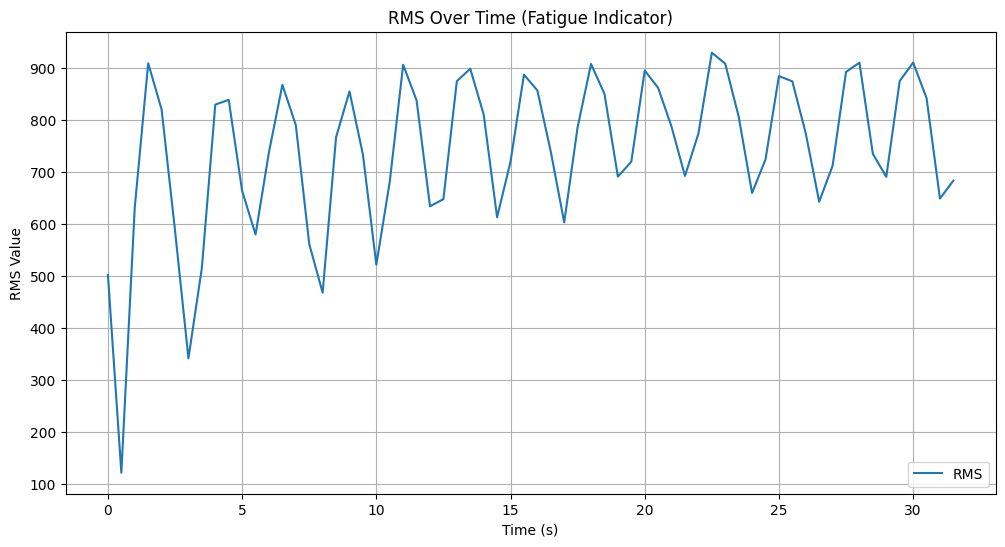

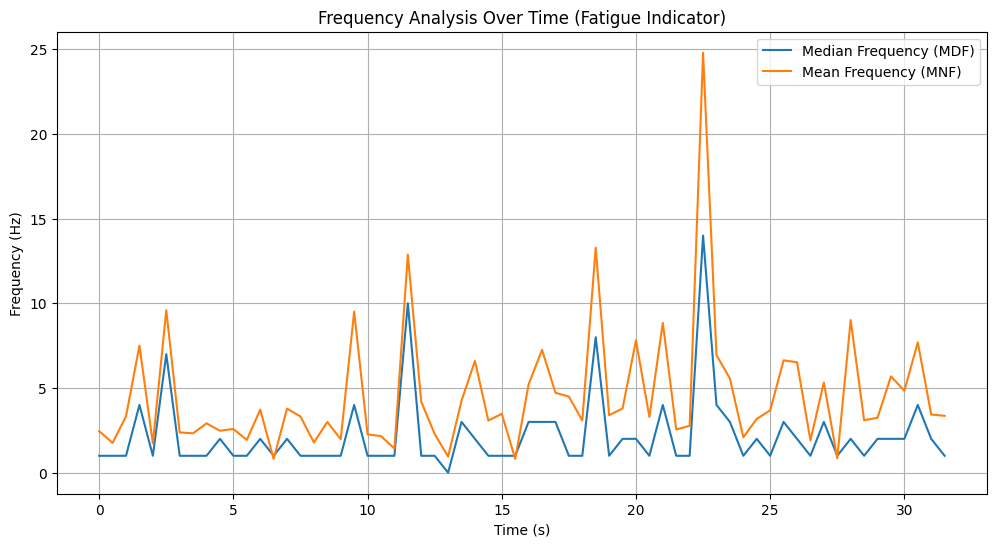

In [ ]:

# # Print first few rows to verify data loading
# print(data.head())

# Extract signal and time
time = data['Timestamp (ms)'].values
signal = data['EMG Value'].values

# # Verify that the signal and time have data
# if len(time) == 0 or len(signal) == 0:
#     print("Data is empty!")
# else:
#     print(f"Loaded {len(time)} samples")

# Parameters
sampling_rate = 450  # Assume a sampling rate of 1000 Hz (update if known)
window_size = 450    # 5 seconds window
overlap = 225        # 50% overlap

# Initialize lists to store features
rms_values = []
median_frequencies = []
mean_frequencies = []

# Analyze data in windows
for start in range(0, len(signal) - window_size, overlap):
    end = start + window_size
    segment = signal[start:end]

    # # Debug: Print the segment to check if it has data
    # print(f"Processing window {start}-{end}")
    # print(f"Segment values: {segment[:10]}...")  # Print first 10 values of the segment

    # Time-Domain Feature: RMS
    rms = np.sqrt(np.mean(segment**2))
    rms_values.append(rms)

    # Frequency-Domain Features: Welch's PSD
    freqs, psd = welch(segment, fs=sampling_rate, nperseg=window_size)

    # # Debug: Print first few values of PSD and frequencies
    # print(f"Frequencies: {freqs[:5]}...")
    # print(f"PSD values: {psd[:5]}...")

    # Median Frequency (MDF)
    if np.sum(psd) > 0:  # Ensure we have non-zero PSD values
        median_freq = freqs[np.cumsum(psd) >= np.sum(psd) / 2][0]  # Median Frequency
        median_frequencies.append(median_freq)
    else:
        median_frequencies.append(np.nan)

    # Mean Frequency (MNF)
    if np.sum(psd) > 0:  # Ensure we have non-zero PSD values
        mean_freq = np.sum(freqs * psd) / np.sum(psd)  # Mean Frequency
        mean_frequencies.append(mean_freq)
    else:
        mean_frequencies.append(np.nan)

    # # Debug: Check if values are being calculated
    # print(f"Window {start}-{end}, RMS: {rms}, MDF: {median_freq}, MNF: {mean_freq}")

# Time axis for windows
window_times = np.arange(0, len(rms_values)) * (window_size - overlap) / sampling_rate

# # Check if features have been calculated
# if len(rms_values) == 0:
#     print("RMS values are empty!")
# if len(median_frequencies) == 0:
#     print("Median frequencies are empty!")
# if len(mean_frequencies) == 0:
#     print("Mean frequencies are empty!")

# Plot RMS over time
plt.figure(figsize=(12, 6))
plt.plot(window_times, rms_values, label="RMS")
plt.xlabel("Time (s)")
plt.ylabel("RMS Value")
plt.title("RMS Over Time (Fatigue Indicator)")
plt.legend()
plt.grid()

# Plot Frequency Analysis over time
plt.figure(figsize=(12, 6))
plt.plot(window_times, median_frequencies, label="Median Frequency (MDF)")
plt.plot(window_times, mean_frequencies, label="Mean Frequency (MNF)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency Analysis Over Time (Fatigue Indicator)")
plt.legend()
plt.grid()

plt.show()

**Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, find_peaks

**Functions**

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def calculate_rms(segment):
  """Calculate the Root Mean Square (RMS) of a signal."""
  return np.sqrt(np.mean(segment**2))

def calculate_mav(segment):
  """Calculate the Mean Absolute Value (MAV) of a signal."""
  return np.mean(np.abs(segment))

def calculate_median_frequency(segment, fs):
  """Calculate the Median Frequency (MDF) of a signal."""
  freqs, psd = welch(segment, fs=fs, nperseg=len(segment))
  cumulative_power = np.cumsum(psd)
  median_index = np.where(cumulative_power >= cumulative_power[-1] / 2)[0][0]
  return freqs[median_index]


**Parameters and Analysis**

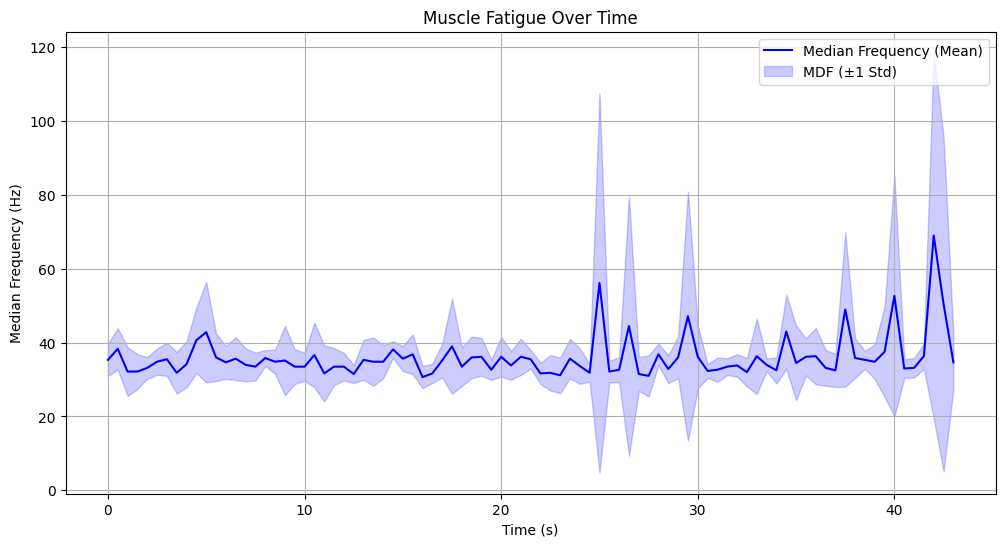

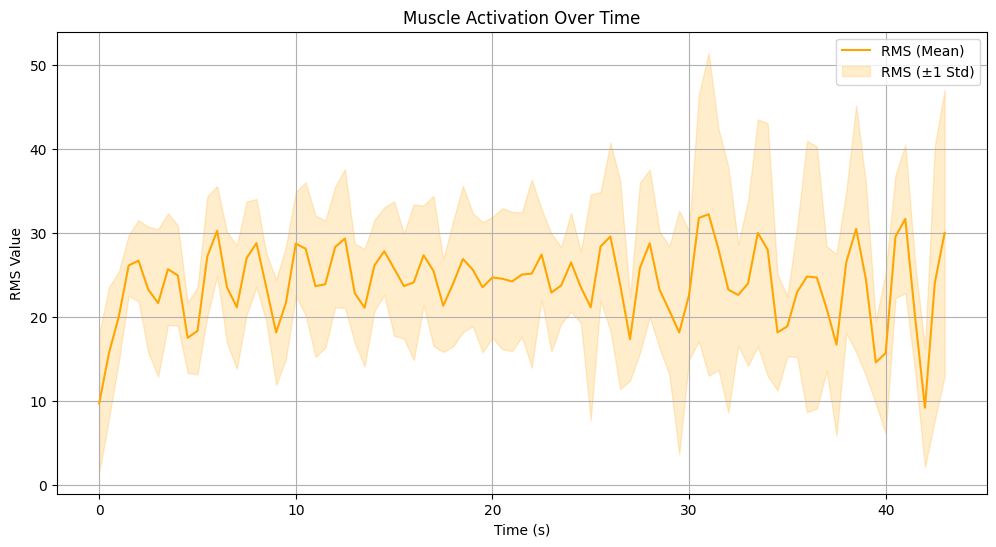

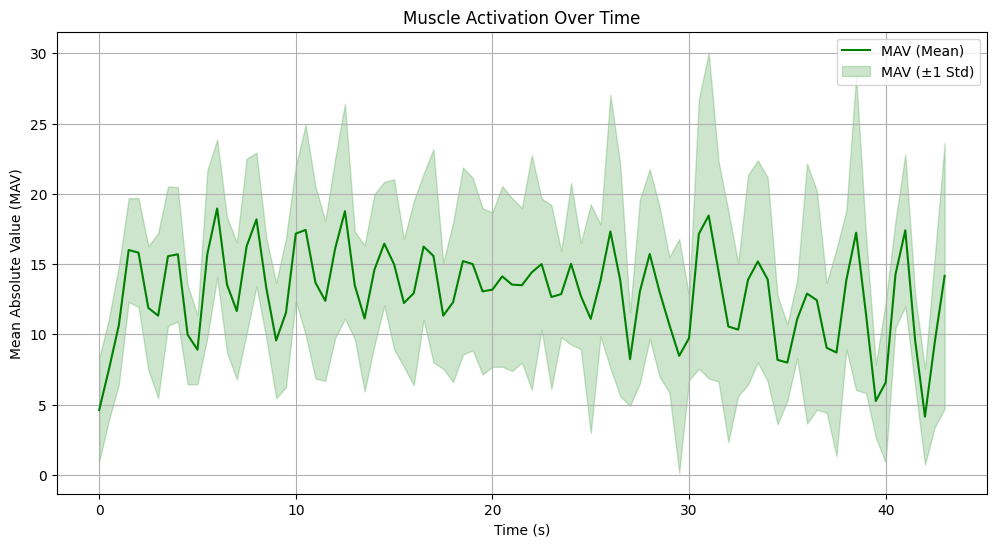

In [ ]:
# File list
file_list = ['emg_left45_01.csv', 'emg_left45_02.csv', 'emg_left45_03.csv',
             'emg_left45_04.csv', 'emg_left45_05.csv', 'emg_left45_06.csv']

# Parameters
fs = 500  # Sampling rate in Hz (500 samples per second)
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 249  # High cutoff frequency (Hz)
window_size = fs * 1  # 1-second window (500 samples)
stride = window_size // 2  # 50% overlap (250 samples)

# Analysis
all_features = []  # Store features for all files

for file in file_list:
    # Load data
    url = f'https://raw.githubusercontent.com/steven-n-wilson/patternClassificationData/refs/heads/main/{file}'
    data = pd.read_csv(url)

    # print(f"Number of rows in {file}: {len(data)}")
    # print(f"Expected duration: {len(data) / fs} seconds")  # Should print 45.0

    # Normalize time to seconds
    data['Time (s)'] = data['Timestamp (ms)'] / 1000
    # print(f"Time range: {data['Time (s)'].min()} to {data['Time (s)'].max()} seconds")  # Should print 0 to 45

    # Remove baseline bias
    data['EMG_Centered'] = data['EMG Value'] - data['EMG Value'].mean()

    # Apply bandpass filter
    data['EMG_Filtered'] = bandpass_filter(data['EMG_Centered'], lowcut, highcut, fs)

    # Segment the data
    segments = [
        data['EMG_Filtered'][i:i + window_size].dropna().values
        for i in range(0, len(data['EMG_Filtered']) - window_size + 1, stride)
    ]
    # print(f"Number of segments: {len(segments)}")
    # print(f"Expected duration from segments: {len(segments) * stride / fs} seconds")

    # Time normalization
    times = np.arange(len(segments)) * stride / fs
    # print(f"Time range after segmentation: {times.min()} to {times.max()} seconds")

    # Feature extraction
    rms_values = [calculate_rms(segment) for segment in segments]
    mav_values = [calculate_mav(segment) for segment in segments]
    median_frequencies = [calculate_median_frequency(segment, fs) for segment in segments]

    # Store features
    file_features = pd.DataFrame({
        'File': file,
        'Time (s)': times,
        'RMS': rms_values,
        'MAV': mav_values,
        'MDF': median_frequencies
    })
    all_features.append(file_features)

# Combine all features into one DataFrame
all_features_df = pd.concat(all_features, ignore_index=True)

# Save results to a CSV file
all_features_df.to_csv('all_features.csv', index=False)

# --- Aggregate Features Across Files ---
aggregated_features = all_features_df.groupby('Time (s)').agg(
    RMS_mean=('RMS', 'mean'),
    RMS_std=('RMS', 'std'),
    MAV_mean=('MAV', 'mean'),
    MAV_std=('MAV', 'std'),
    MDF_mean=('MDF', 'mean'),
    MDF_std=('MDF', 'std')
).reset_index()

# --- Visualization of Muscle Fatigue ---
# Plot Median Frequency (MDF)
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features['MDF_mean'], label='Median Frequency (Mean)', color='blue')
plt.fill_between(
    aggregated_features['Time (s)'],
    aggregated_features['MDF_mean'] - aggregated_features['MDF_std'],
    aggregated_features['MDF_mean'] + aggregated_features['MDF_std'],
    color='blue', alpha=0.2, label='MDF (±1 Std)'
)
plt.xlabel("Time (s)")
plt.ylabel("Median Frequency (Hz)")
plt.title("Muscle Fatigue Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot RMS
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features['RMS_mean'], label='RMS (Mean)', color='orange')
plt.fill_between(
    aggregated_features['Time (s)'],
    aggregated_features['RMS_mean'] - aggregated_features['RMS_std'],
    aggregated_features['RMS_mean'] + aggregated_features['RMS_std'],
    color='orange', alpha=0.2, label='RMS (±1 Std)'
)
plt.xlabel("Time (s)")
plt.ylabel("RMS Value")
plt.title("Muscle Activation Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAV
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features['MAV_mean'], label='MAV (Mean)', color='green')
plt.fill_between(
    aggregated_features['Time (s)'],
    aggregated_features['MAV_mean'] - aggregated_features['MAV_std'],
    aggregated_features['MAV_mean'] + aggregated_features['MAV_std'],
    color='green', alpha=0.2, label='MAV (±1 Std)'
)
plt.xlabel("Time (s)")
plt.ylabel("Mean Absolute Value (MAV)")
plt.title("Muscle Activation Over Time")
plt.legend()
plt.grid(True)
plt.show()


Fatigue threshold detected in MDF_mean at 24.50 seconds.
Fatigue threshold detected in RMS_mean at 0.00 seconds.
Fatigue threshold detected in MAV_mean at 1.00 seconds.


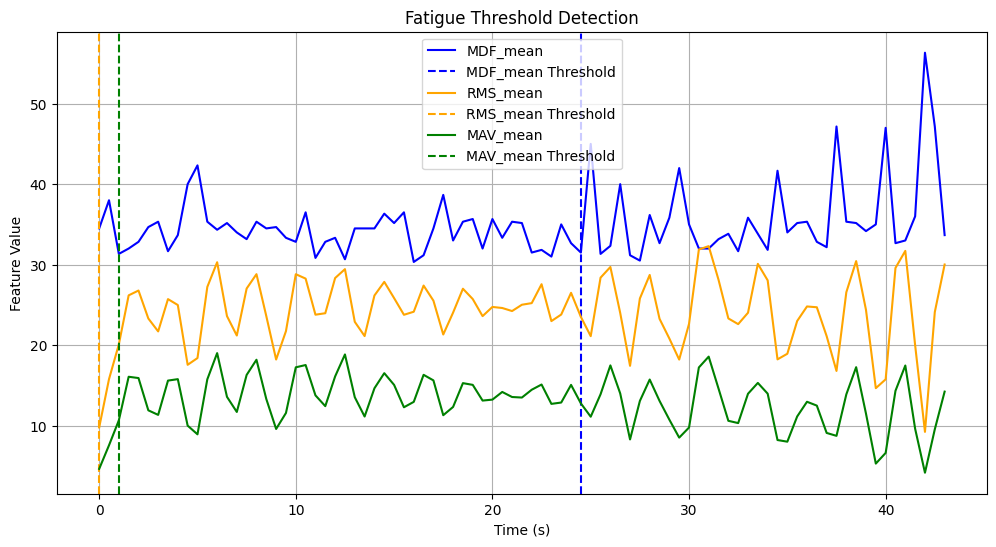

In [ ]:
# --- Change Point Detection Function ---
def detect_fatigue_threshold(data, feature, sensitivity=1.5):
    """
    Detect the fatigue threshold as the first significant change in a feature's trend.

    Parameters:
    - data: DataFrame containing the feature over time.
    - feature: The column name of the feature to analyze (e.g., 'MDF', 'RMS').
    - sensitivity: Multiplier for standard deviation to define a significant change.

    Returns:
    - threshold_time: The time (in seconds) where fatigue is detected.
    """
    values = data[feature]
    times = data['Time (s)']

    # Calculate the derivative (rate of change)
    derivative = np.gradient(values)

    # Define a threshold for significant change
    std_dev = np.std(derivative)
    change_points = np.where(abs(derivative) > sensitivity * std_dev)[0]

    if len(change_points) > 0:
        threshold_time = times.iloc[change_points[0]]
        return threshold_time
    else:
        return None

# --- Apply Fatigue Threshold Detection ---
fatigue_thresholds = {}
for feature in ['MDF_mean', 'RMS_mean', 'MAV_mean']:
    threshold_time = detect_fatigue_threshold(aggregated_features, feature, sensitivity=1.5)
    fatigue_thresholds[feature] = threshold_time
    if threshold_time is not None:
        print(f"Fatigue threshold detected in {feature} at {threshold_time:.2f} seconds.")
    else:
        print(f"No significant fatigue threshold detected in {feature}.")

# --- Plot Fatigue Thresholds ---
plt.figure(figsize=(12, 6))
for feature, color in zip(['MDF_mean', 'RMS_mean', 'MAV_mean'], ['blue', 'orange', 'green']):
    plt.plot(aggregated_features['Time (s)'], aggregated_features[feature], label=feature, color=color)
    if fatigue_thresholds[feature] is not None:
        plt.axvline(x=fatigue_thresholds[feature], color=color, linestyle='--', label=f'{feature} Threshold')

plt.xlabel("Time (s)")
plt.ylabel("Feature Value")
plt.title("Fatigue Threshold Detection")
plt.legend()
plt.grid(True)
plt.show()

Detected 19 repetitions at times: [ 2.   3.5  6.   8.  10.  12.5 14.5 16.5 18.5 20.  22.5 24.  26.  28.
 31.  33.5 36.  38.5 41. ]


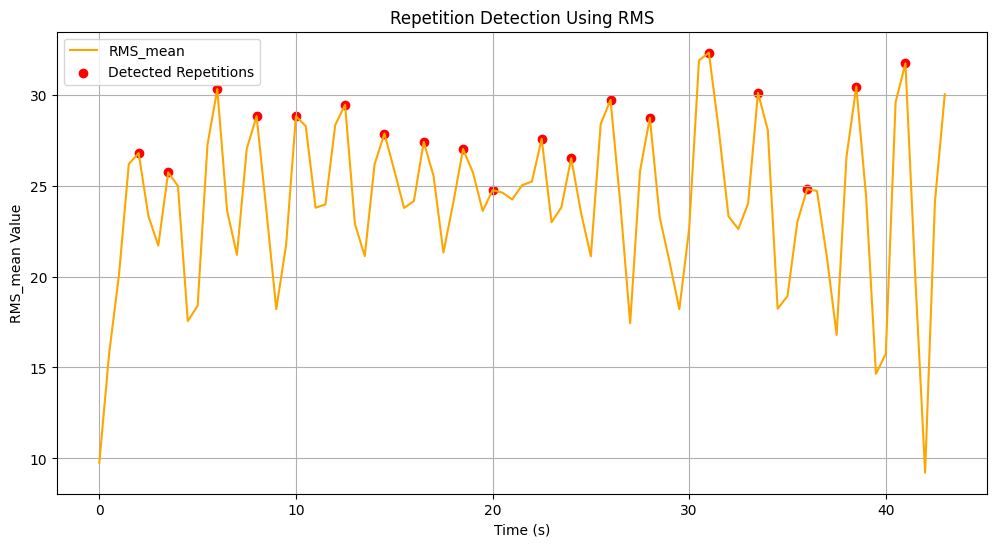

In [ ]:
# --- Repetition Detection Function ---
def detect_repetitions(data, feature, height=None, distance=None):
    """
    Detect repetitions based on peaks in a given feature (e.g., RMS, MAV).

    Parameters:
    - data: DataFrame containing the feature over time.
    - feature: The column name of the feature to analyze (e.g., 'RMS_mean', 'MAV_mean').
    - height: Minimum height of peaks to detect (optional).
    - distance: Minimum distance between peaks in seconds (optional, converted to samples).

    Returns:
    - peaks: Indices of detected peaks.
    - peak_times: Times (in seconds) of the detected peaks.
    """
    values = data[feature].values
    times = data['Time (s)'].values

    # Detect peaks
    peaks, _ = find_peaks(values, height=height, distance=distance)
    peak_times = times[peaks]

    return peaks, peak_times

# --- Apply Repetition Detection ---
repetition_feature = 'RMS_mean'  # Use RMS or MAV for repetition detection
min_height = 10  # Set a reasonable height threshold (adjust based on signal)
min_distance = 1.0 * fs / stride  # Set a minimum distance of 1 second between peaks

# Detect repetitions
peaks, peak_times = detect_repetitions(aggregated_features, repetition_feature, height=min_height, distance=min_distance)
print(f"Detected {len(peaks)} repetitions at times: {peak_times}")

# --- Plot Detected Repetitions ---
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features[repetition_feature], label=f'{repetition_feature}', color='orange')
plt.scatter(peak_times, aggregated_features[repetition_feature].iloc[peaks], color='red', label='Detected Repetitions')
plt.xlabel("Time (s)")
plt.ylabel(f"{repetition_feature} Value")
plt.title("Repetition Detection Using RMS")
plt.legend()
plt.grid(True)
plt.show()

**Machine Learning Model to Detect the Fatigue Threshold**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load your aggregated features
# Ensure `aggregated_features` has ['Time (s)', 'RMS_mean', 'MAV_mean', 'MDF_mean', 'RMS_std', 'MAV_std', 'MDF_std']

# Define the fatigue threshold (from detected MDF fatigue threshold or manually set)
fatigue_time = 25  # Replace with your actual fatigue threshold time

# Add binary labels: 0 for "not fatigued", 1 for "fatigued"
aggregated_features['Fatigued'] = (aggregated_features['Time (s)'] >= fatigue_time).astype(int)

# Define features and labels
X = aggregated_features[['RMS_mean', 'MAV_mean', 'MDF_mean', 'RMS_std', 'MAV_std', 'MDF_std']]
y = aggregated_features['Fatigued']

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 69, Testing samples: 18


**Train Random Forest Classifier**

In [ ]:
# Train a Random Forest Classifier with fine-tuned parameters
rf_model = RandomForestClassifier(
    n_estimators=200,        # More estimators for better averaging
    max_depth=10,            # Limit depth to prevent overfitting
    min_samples_split=10,    # Require at least 10 samples to split a node
    min_samples_leaf=5,      # Require at least 5 samples in leaf nodes
    random_state=42
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7222222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.73      0.80      0.76        10

    accuracy                           0.72        18
   macro avg       0.72      0.71      0.71        18
weighted avg       0.72      0.72      0.72        18



**Evaluate Model**

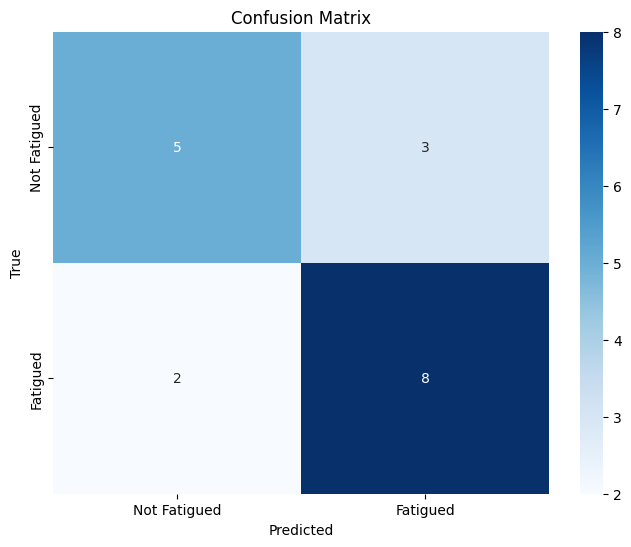

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fatigued', 'Fatigued'], yticklabels=['Not Fatigued', 'Fatigued'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**Temporal Smoothing**

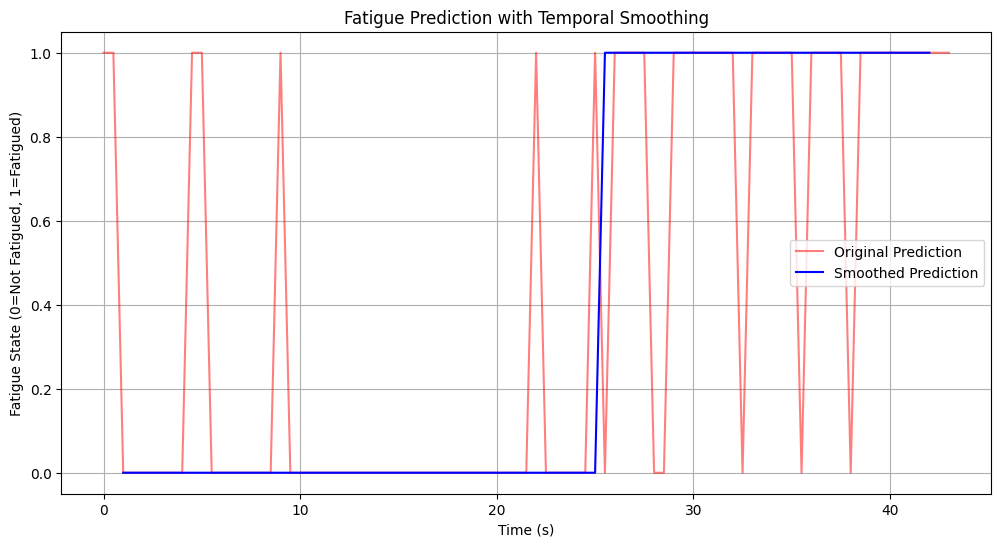

In [ ]:
# Predict fatigue state for the entire dataset
aggregated_features['Predicted_Fatigued'] = rf_model.predict(X_scaled)

# Apply rolling average for temporal smoothing
aggregated_features['Smoothed_Fatigued'] = aggregated_features['Predicted_Fatigued'].rolling(window=5, center=True).mean().round()

# Plot smoothed predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features['Predicted_Fatigued'], label='Original Prediction', color='red', alpha=0.5)
plt.plot(aggregated_features['Time (s)'], aggregated_features['Smoothed_Fatigued'], label='Smoothed Prediction', color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Fatigue State (0=Not Fatigued, 1=Fatigued)")
plt.title("Fatigue Prediction with Temporal Smoothing")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-28-8657cd8120b0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette='viridis')


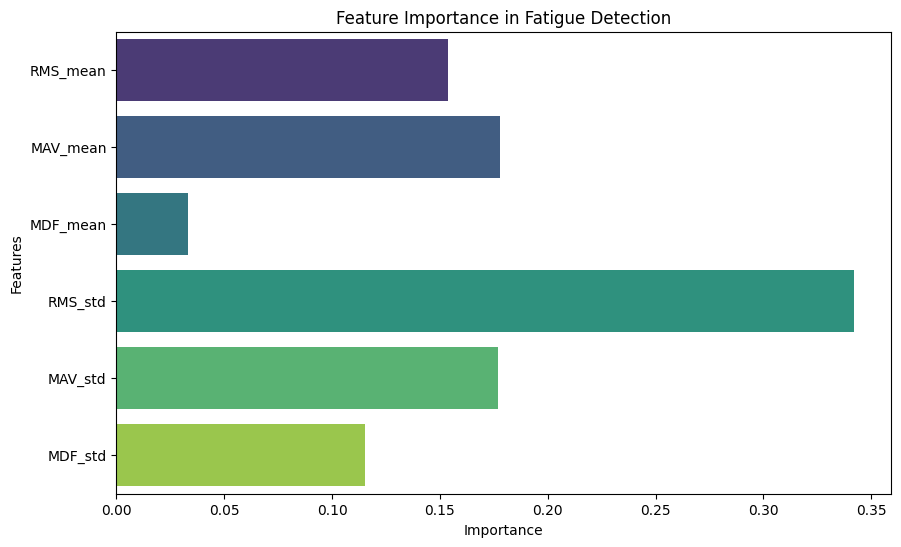

In [ ]:
# Feature importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette='viridis')
plt.title("Feature Importance in Fatigue Detection")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



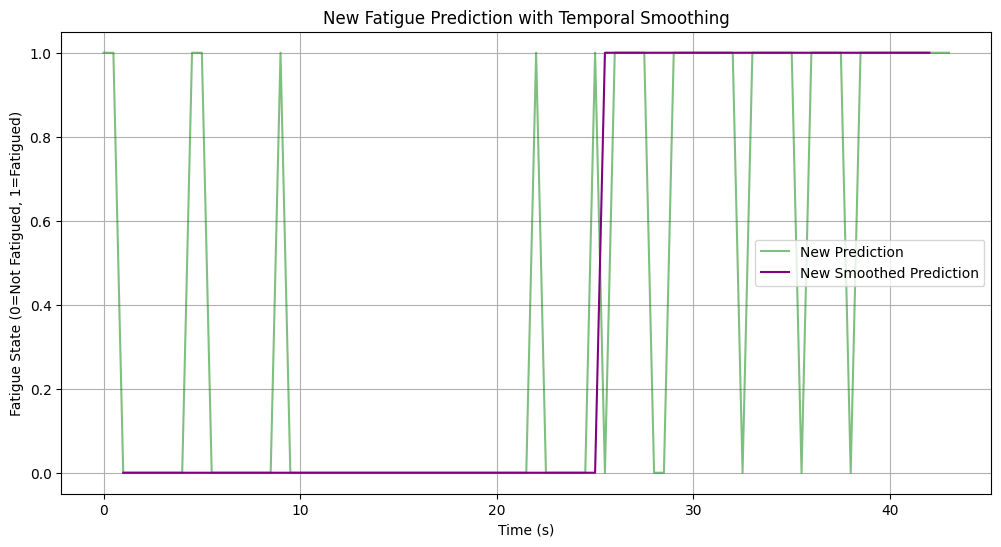

In [ ]:
# Predict on new session data
new_session_data = aggregated_features[['RMS_mean', 'MAV_mean', 'MDF_mean', 'RMS_std', 'MAV_std', 'MDF_std']]
new_session_scaled = scaler.transform(new_session_data)

# Predict and smooth
aggregated_features['New_Predicted_Fatigued'] = rf_model.predict(new_session_scaled)
aggregated_features['New_Smoothed_Fatigued'] = aggregated_features['New_Predicted_Fatigued'].rolling(window=5, center=True).mean().round()

# Plot new predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_features['Time (s)'], aggregated_features['New_Predicted_Fatigued'], label='New Prediction', color='green', alpha=0.5)
plt.plot(aggregated_features['Time (s)'], aggregated_features['New_Smoothed_Fatigued'], label='New Smoothed Prediction', color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Fatigue State (0=Not Fatigued, 1=Fatigued)")
plt.title("New Fatigue Prediction with Temporal Smoothing")
plt.legend()
plt.grid(True)
plt.show()

